In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy

from collections import defaultdict
from copy import deepcopy
from tqdm.notebook import tqdm

rng = np.random.default_rng(42)

In [2]:
import matplotlib as mpl
new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

In [3]:
# Taken from
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

In [4]:
# Set up three policies: logging, prod, target
# Compute (SN)IPS estimates with CIs for prod, target
# Compute CIs for differences
# Show that it can have lower variance, and hence be helpful for monotonic improvements with small steps (TRPO-style)

In [5]:
# General info about the problem
D = 3

# Logging policy
# Set it up s.t. the density is constant 1 for all observed data
a_min, a_max = 0.0, 1.0
# pi_0 = scipy.stats.uniform(a_min, a_max-a_min)

# # Function to generate samples
# def generate_samples(pi_0, N, D):
#     return pi_0.rvs(N*D).reshape((N,D))

pi_0 = scipy.stats.multivariate_normal(np.ones(D) * 0.475, 0.5)

# Function to generate samples
def generate_samples(pi_0, N, D):
    return pi_0.rvs(N)

# Production policy
mu_p = np.ones(D) * 0.5

# Target policy
mu_t = np.ones(D) * 0.505

# Reward function
reward = lambda a: np.mean(a, axis=-1)  + scipy.stats.norm(0, 0.25).rvs(len(a))

# Reward
#P_r = 0.1
#reward = lambda a: rng.poisson(np.clip(np.mean(a, axis=-1)*P_r, 0, None))
#true_E_R = P_r * mu1
true_delta = np.mean(mu_t, axis=-1) - np.mean(mu_p, axis=-1)
#true_delta = np.mean(mu_t, axis=-1)*P_r - np.mean(mu_p, axis=-1)*P_r
true_delta

0.0050000000000000044

In [6]:
import scipy.optimize 

def IPS_estimate(A, R, pi):
    estimates = R* (pi.pdf(A) / pi_0.pdf(A))
    
    var_estimates = np.sum((estimates-np.mean(estimates))**2) / (len(A)-1)

    return np.mean(estimates), np.sqrt(var_estimates) /np.sqrt(len(A))

def SNIPS_estimate(A, R, pi):
    estimates_numer = (pi.pdf(A) / pi_0.pdf(A)) * R
    estimates_denom = (pi.pdf(A) / pi_0.pdf(A))

    estimates_mean = np.sum(estimates_numer) / np.sum(estimates_denom)
    
    N = len(A)

    var_estimates = np.sum((estimates_numer - estimates_mean*estimates_denom)**2) / (estimates_denom.mean()**2 * (N-1))
    
    return np.sum(estimates_numer) / np.sum(estimates_denom), np.sqrt(var_estimates / N)

def beta_IPS_estimate(A, R, pi):
    beta = np.mean(R * ((pi.pdf(A) / pi_0.pdf(A))**2 - (pi.pdf(A) / pi_0.pdf(A)))) / np.mean((pi.pdf(A) / pi_0.pdf(A))**2 - (pi.pdf(A) / pi_0.pdf(A)))
    
    estimates = beta + (R-beta) * (pi.pdf(A) / pi_0.pdf(A))
        
    var_estimates = np.sum((estimates-np.mean(estimates))**2) / (len(A)-1)

    return np.mean(estimates), np.sqrt(var_estimates) /np.sqrt(len(A))

def dIPS_estimate(A, R, pi_A, pi_B):
    estimates_A = (pi_A.pdf(A) / pi_0.pdf(A)) * R
    estimates_B = (pi_B.pdf(A) / pi_0.pdf(A)) * R

    return np.mean(estimates_A - estimates_B), np.sqrt(np.var(estimates_A-estimates_B))/np.sqrt(len(A))

#     estimates_A = (pi_A.pdf(A) / pi_0.pdf(A)) * R
#     estimates_B = (pi_B.pdf(A) / pi_0.pdf(A)) * R
#     cov = np.sum((estimates_A - np.mean(estimates_A))*(estimates_B - np.mean(estimates_B)))/(len(A)-1)

#     diff_var = np.var(estimates_A)+ np.var(estimates_B)-2*cov
    
#     if diff_var < 0.0:
#         diff_var = 1e-12
#     return np.mean(estimates_A) - np.mean(estimates_B), np.sqrt(diff_var)/np.sqrt(len(A))


def dSNIPS_estimate(A, R, pi_A, pi_B):
    estimates_numer_A = (pi_A.pdf(A) / pi_0.pdf(A)) * R
    estimates_denom_A = (pi_A.pdf(A) / pi_0.pdf(A))
    estimates_numer_B = (pi_B.pdf(A) / pi_0.pdf(A)) * R
    estimates_denom_B = (pi_B.pdf(A) / pi_0.pdf(A))
    
    diff_estimates_mean = estimates_numer_A.sum()/estimates_denom_A.sum() - estimates_numer_B.sum()/estimates_denom_B.sum() 
    
    # Delta method for variance (from Aleksei)
    g = np.asarray([
        1.0/estimates_denom_A.mean(),
        -estimates_numer_A.mean()/(estimates_denom_A.mean()**2),
        -1.0/estimates_denom_B.mean(),
        estimates_numer_B.mean()/(estimates_denom_B.mean()**2),
    ])
    cov = np.cov(np.vstack([estimates_numer_A, estimates_denom_A, estimates_numer_B, estimates_denom_B]))
    
    diff_estimates_var = g@cov@g.T
    
    return diff_estimates_mean, np.sqrt(diff_estimates_var) / np.sqrt(len(A))

    #return diff_estimates_mean, diff_estimates_var / np.sqrt(len(A))

def dSNIPS2_estimate(A, R, pi_A, pi_B):
    estimates_numer = (pi_A.pdf(A) - pi_B.pdf(A)) / pi_0.pdf(A) * R
    estimates_denom = 1.0 + (pi_A.pdf(A) - pi_B.pdf(A)) / pi_0.pdf(A)

    estimates_mean = np.sum(estimates_numer) / np.sum(estimates_denom)
    
    N = len(A)

    var_estimates = np.sum((estimates_numer - estimates_mean*estimates_denom)**2) / (estimates_denom.mean()**2 * (N-1))
    
    return np.sum(estimates_numer) / np.sum(estimates_denom), np.sqrt(var_estimates / N)


def beta_dIPS_estimate(A, R, pi_A, pi_B):
    square_W_diff = ((pi_A.pdf(A)-pi_B.pdf(A))/pi_0.pdf(A))**2 #- (pi_A.pdf(A)-pi_B.pdf(A))/pi_0.pdf(A)
    beta = np.mean(R * square_W_diff) / np.mean(square_W_diff)
    estimates_diff = (R-beta)*(pi_A.pdf(A)-pi_B.pdf(A))/pi_0.pdf(A)
    return np.mean(estimates_diff), np.sqrt(np.var(estimates_diff))/np.sqrt(len(A))

    def beta_dIPS_var(beta):
        return np.var((R-beta)*(pi_A.pdf(A)-pi_B.pdf(A))/pi_0.pdf(A))

    #opt_beta = scipy.optimize.golden(beta_dIPS_var)
    #print(beta, opt_beta)
    estimates_diff = (R-opt_beta)*(pi_A.pdf(A)-pi_B.pdf(A))/pi_0.pdf(A)
    return np.mean(estimates_diff), np.sqrt(np.var(estimates_diff))/np.sqrt(len(A))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

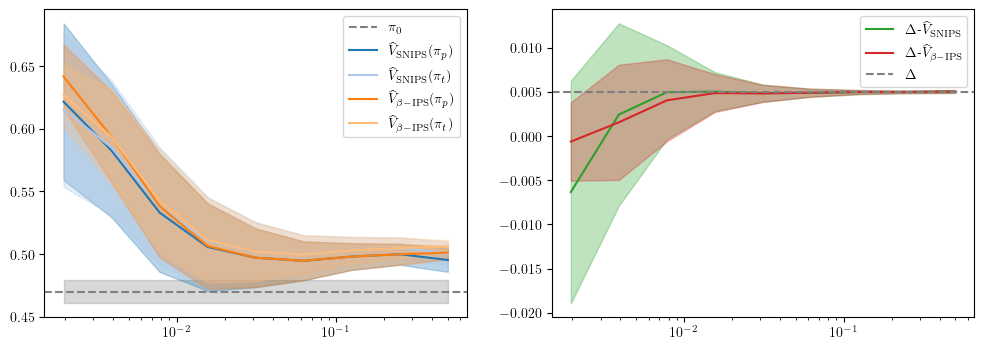

In [7]:
#sigmas = np.logspace(-1.85,0,20)
# sigmas = np.logspace(-2.2,-0.25,20)
# sigmas = np.logspace(-2.1,0.0,20)
#sigmas = np.sort(np.concatenate((sigmas, 0.5*sigmas)))

sigmas = 0.5** np.arange(1, 10)[::-1]

N = 10_000
A = generate_samples(pi_0, N, D)
R = reward(A)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].axhline(np.mean(R), ls='--', color='gray', label=r'$\pi_{0}$')
axes[0].fill_between(sigmas,
                 np.mean(R)-1.96*scipy.stats.sem(R),
                 np.mean(R)+1.96*scipy.stats.sem(R),
                 color='gray', alpha=.3)

estimators = [
#    (r'$\widehat{V}_{\rm IPS}', IPS_estimate, dIPS_estimate),
    (r'$\widehat{V}_{\rm SNIPS}', SNIPS_estimate, dSNIPS_estimate),
#    (r'$\widehat{V}_{\rm SNIPS2}', SNIPS_estimate, dSNIPS2_estimate),
    (r'$\widehat{V}_{\beta{\rm -IPS}}', beta_IPS_estimate, beta_dIPS_estimate),

]

for idx, (estimator_name, estimator, diff_estimator) in enumerate(estimators):

    R_hats_mean_p, R_hats_mean_t = [], []
    R_hats_stderr_p, R_hats_stderr_t = [], []

    R_diffs_mean = []
    R_diffs_stderr = []
    for sigma in tqdm(sigmas):
        R_hat_mean_p, R_hat_stderr_p = estimator(A, R, scipy.stats.multivariate_normal(mu_p, sigma))
        R_hat_mean_t, R_hat_stderr_t = estimator(A, R, scipy.stats.multivariate_normal(mu_t, sigma))     
        #R_hat_mean_p, R_hat_stderr_p = IPS_estimate(A, R, scipy.stats.multivariate_normal(mu_p, sigma), beta=0.0)
        #R_hat_mean_t, R_hat_stderr_t = IPS_estimate(A, R, scipy.stats.multivariate_normal(mu_t, sigma), beta=0.0)
        #R_hat_mean_p, R_hat_stderr_p = SNIPS_estimate(A, R, scipy.stats.multivariate_normal(mu_p, sigma))
        #R_hat_mean_t, R_hat_stderr_t = SNIPS_estimate(A, R, scipy.stats.multivariate_normal(mu_t, sigma))

        R_diff_mean, R_diff_stderr = diff_estimator(A,
                                                    R,
                                                    scipy.stats.multivariate_normal(mu_t, sigma),
                                                    scipy.stats.multivariate_normal(mu_p, sigma))
        #R_diff_mean, R_diff_stderr = dIPS_estimate(A,
        #                                           R,
        #                                           scipy.stats.multivariate_normal(mu_t, sigma),
        #                                           scipy.stats.multivariate_normal(mu_p, sigma),
        #                                           beta=0.0)
        #R_diff_mean, R_diff_stderr = dSNIPS_estimate(A,
        #                                             R,
        #                                             scipy.stats.multivariate_normal(mu_t, sigma),
        #                                             scipy.stats.multivariate_normal(mu_p, sigma))
        R_hats_mean_p.append(R_hat_mean_p)
        R_hats_mean_t.append(R_hat_mean_t)
        R_hats_stderr_p.append(R_hat_stderr_p)
        R_hats_stderr_t.append(R_hat_stderr_t)

        R_diffs_mean.append(R_diff_mean)
        R_diffs_stderr.append(R_diff_stderr)

    R_hats_mean_p = np.asarray(R_hats_mean_p)
    R_hats_mean_t = np.asarray(R_hats_mean_t)
    R_hats_stderr_p = np.asarray(R_hats_stderr_p)
    R_hats_stderr_t = np.asarray(R_hats_stderr_t)

    R_diffs_mean = np.asarray(R_diffs_mean)
    R_diffs_stderr = np.asarray(R_diffs_stderr)

    axes[0].plot(sigmas, R_hats_mean_p, label=estimator_name+r'(\pi_p)$', color=tableau20[2*idx])
    axes[0].fill_between(sigmas,
                     R_hats_mean_p-1.96*R_hats_stderr_p,
                     R_hats_mean_p+1.96*R_hats_stderr_p,
                     alpha=.3, color=tableau20[2*idx])

    axes[0].plot(sigmas, R_hats_mean_t, label=estimator_name+r'(\pi_t)$', color=tableau20[2*idx+1])
    axes[0].fill_between(sigmas,
                     R_hats_mean_t-1.96*R_hats_stderr_t,
                     R_hats_mean_t+1.96*R_hats_stderr_t,
                     alpha=.3, color=tableau20[2*idx+1])

    axes[1].plot(sigmas, R_diffs_mean, color=tableau20[len(estimators)*2+2*idx], label=r'$\Delta$-'+estimator_name+'$')
    axes[1].fill_between(sigmas,
                     R_diffs_mean-1.96*R_diffs_stderr,
                     R_diffs_mean+1.96*R_diffs_stderr,
                     alpha=.3, color=tableau20[len(estimators)*2+2*idx])
    
axes[1].axhline(true_delta, ls='--', color='gray', label=r'$\Delta$')
axes[0].set_xscale('log')
axes[0].legend()
axes[1].set_xscale('log')
axes[1].legend()
#plt.yscale('log')
plt.show()

## MSE, Variance, Coverage

In [8]:
estimator2colour = {
    r'$\widehat{V}_{\rm IPS}$': tableau20[0],
    r'$\widehat{V}_{\beta{\rm -IPS}}$': tableau20[4],
    r'$\widehat{V}_{\rm SNIPS}$': tableau20[2],
    r'$\widehat{V}_{\Delta{\rm -IPS}}$': tableau20[1],
    r'$\widehat{V}_{\Delta{\rm -SNIPS}}$': tableau20[3],
    r'$\widehat{V}_{\Delta\beta{\rm -IPS}}$': tableau20[5]
}
estimator2marker = {
    r'$\widehat{V}_{\rm IPS}$': 's',
    r'$\widehat{V}_{\Delta{\rm -IPS}}$': 'D',
    r'$\widehat{V}_{\rm SNIPS}$': 'v',
    r'$\widehat{V}_{\Delta{\rm -SNIPS}}$': '^',
    r'$\widehat{V}_{\beta{\rm -IPS}}$': 'x',
    r'$\widehat{V}_{\Delta\beta{\rm -IPS}}$': '+'
}

### Vary $\sigma$

In [9]:
sigmas = 0.5** np.arange(1, 9)[::-1] #np.linspace(0, 10, 10)[::-1]
sigmas

array([0.00390625, 0.0078125 , 0.015625  , 0.03125   , 0.0625    ,
       0.125     , 0.25      , 0.5       ])

In [10]:
N = 15_500

estimators = [
    (r'$\widehat{V}_{\Delta{\rm -IPS}}$',  dIPS_estimate),
    (r'$\widehat{V}_{\Delta{\rm -SNIPS}}$', dSNIPS_estimate),
#    (r'$\widehat{V}_{\Delta{\rm -SNIPS2}}$', dSNIPS2_estimate),
    (r'$\widehat{V}_{\Delta\beta{\rm -IPS}}$', beta_dIPS_estimate),

]
pointwise_estimators = [
    (r'$\widehat{V}_{\rm IPS}$',  IPS_estimate),
    (r'$\widehat{V}_{\rm SNIPS}$', SNIPS_estimate),
    (r'$\widehat{V}_{\beta{\rm -IPS}}$', beta_IPS_estimate),

]


num_iter = 100
estimator2sigma2MSE = defaultdict(lambda: defaultdict(list))
estimator2sigma2stderr = defaultdict(lambda: defaultdict(list))
estimator2sigma2coverage = defaultdict(lambda: defaultdict(list))
estimator2sigma2statsig = defaultdict(lambda: defaultdict(list))

for i in tqdm(range(num_iter)):
    A = generate_samples(pi_0, N, D)
    R = reward(A)
 
    for sigma in sigmas:
        
        pi_t = scipy.stats.multivariate_normal(mu_t, sigma)        
        pi_p = scipy.stats.multivariate_normal(mu_p, sigma)
        
    
        # Pairwise estimators
        for idx, (estimator_name, diff_estimator) in enumerate(estimators):
            
            R_diff_mean, R_diff_stderr = diff_estimator(A,
                                                        R,
                                                        pi_t,
                                                        pi_p)
            
            square_error = (R_diff_mean - true_delta)**2
            covered = ((R_diff_mean-1.96*R_diff_stderr) <= true_delta) & ((R_diff_mean+1.96*R_diff_stderr) >= true_delta)
            statsig = (R_diff_mean-1.96*R_diff_stderr) * (R_diff_mean+1.96*R_diff_stderr) > 0.0
            
            estimator2sigma2MSE[estimator_name][sigma].append(square_error)
            estimator2sigma2stderr[estimator_name][sigma].append(R_diff_stderr)
            estimator2sigma2coverage[estimator_name][sigma].append(covered)
            estimator2sigma2statsig[estimator_name][sigma].append(statsig)
            
        # Pointwise estimators
        for estimator_name, estimator in pointwise_estimators:
            R_mean_t, R_stderr_t = estimator(A, R, pi_t)
            R_mean_p, R_stderr_p = estimator(A, R, pi_p)
            R_diff = (R_mean_t - R_mean_p)
            square_error = (R_diff - true_delta)**2
            statsig =  ((R_mean_t+1.96*R_stderr_t)<(R_mean_p-1.96*R_stderr_p)) | ((R_mean_p+1.96*R_stderr_p) < (R_mean_t-1.96*R_stderr_t))
            estimator2sigma2MSE[estimator_name][sigma].append(square_error)
            estimator2sigma2statsig[estimator_name][sigma].append(statsig)        

  0%|          | 0/100 [00:00<?, ?it/s]

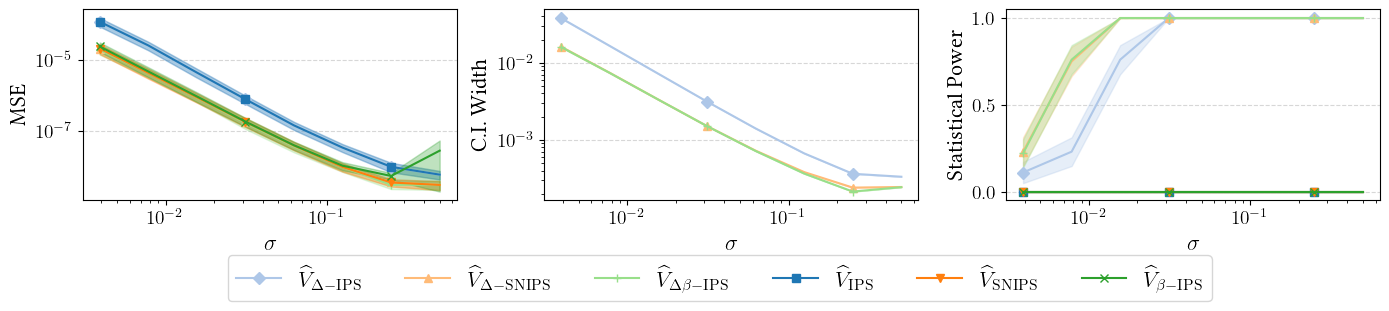

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(14, 2.75))
fontsize=18

for idx, (estimator_name, sigma2MSE) in enumerate(estimator2sigma2MSE.items()):
    sigmas = np.asarray(list(sigma2MSE.keys()))
    
    MSE = np.asarray([
        np.mean(sigma2MSE[sigma]) for sigma in sigmas
    ])
    MSE_stderr = np.asarray([
        np.std(sigma2MSE[sigma]) / np.sqrt(num_iter) for sigma in sigmas
    ])
    
    axes[0].plot(sigmas, MSE, color=estimator2colour[estimator_name], markevery=3, marker=estimator2marker[estimator_name], label=estimator_name)
    axes[0].fill_between(sigmas,
                         MSE-1.96*MSE_stderr,
                         MSE+1.96*MSE_stderr,
                         alpha=.3, color=estimator2colour[estimator_name])
    
    if estimator_name in [e[0] for e in estimators]:
        mean_stderr = np.asarray([
            2.0 * 1.96 * np.mean(estimator2sigma2stderr[estimator_name][sigma]) for sigma in sigmas
        ])
        stderr_stderr = np.asarray([
            np.std(estimator2sigma2stderr[estimator_name][sigma]) / np.sqrt(num_iter) for sigma in sigmas
        ])
        axes[1].plot(sigmas, mean_stderr, color=estimator2colour[estimator_name], markevery=3, marker=estimator2marker[estimator_name], label=estimator_name)
        axes[1].fill_between(sigmas,
                             mean_stderr-1.96*stderr_stderr,
                             mean_stderr+1.96*stderr_stderr,
                             alpha=.3, color=estimator2colour[estimator_name])


    # TODO: Wilson confidence intervals
    mean_statsig = np.asarray([
        np.mean(estimator2sigma2statsig[estimator_name][sigma]) for sigma in sigmas
    ])
    stderr_statsig = np.asarray([
        np.std(estimator2sigma2statsig[estimator_name][sigma]) / np.sqrt(num_iter) for sigma in sigmas
    ])
    
    axes[2].plot(sigmas, mean_statsig, color=estimator2colour[estimator_name], markevery=3, marker=estimator2marker[estimator_name], label=estimator_name)
    axes[2].fill_between(sigmas,
                         mean_statsig-1.96*stderr_statsig,
                         mean_statsig+1.96*stderr_statsig,
                         alpha=.3, color=estimator2colour[estimator_name])


axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$\sigma$', fontsize=fontsize-2)
axes[0].set_ylabel('MSE', fontsize=fontsize-2)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$\sigma$', fontsize=fontsize-2)
axes[1].set_ylabel('C.I. Width', fontsize=fontsize-2)    
axes[2].set_xscale('log')
axes[2].set_xlabel(r'$\sigma$', fontsize=fontsize-2)
axes[2].set_ylabel('Statistical Power', fontsize=fontsize-2)    
    
axes[0].grid(axis='y', ls='--', alpha=.5)
axes[1].grid(axis='y', ls='--', alpha=.5)
axes[2].grid(axis='y', ls='--', alpha=.5)

for ax in axes:
    ax.xaxis.set_tick_params(labelsize=fontsize-4)            
    ax.yaxis.set_tick_params(labelsize=fontsize-4)

fig.tight_layout()
axes[2].legend(fontsize=fontsize-2, ncol=6, loc='upper right', bbox_to_anchor=(0.58,-.23))
    
plt.show()

### Vary $N$

In [12]:

Ns = 2 ** np.linspace(5, 16, 10)
Ns

array([3.20000000e+01, 7.46578585e+01, 1.74181120e+02, 4.06374669e+02,
       9.48095705e+02, 2.21196235e+03, 5.16063662e+03, 1.20400650e+04,
       2.80901708e+04, 6.55360000e+04])

In [13]:
sigma = 0.05

estimators = [
    (r'$\widehat{V}_{\Delta{\rm -IPS}}$',  dIPS_estimate),
    (r'$\widehat{V}_{\Delta{\rm -SNIPS}}$', dSNIPS_estimate),
#    (r'$\widehat{V}_{\Delta{\rm -SNIPS2}}$', dSNIPS2_estimate),
    (r'$\widehat{V}_{\Delta\beta{\rm -IPS}}$', beta_dIPS_estimate),

]

num_iter = 1000
estimator2N2MSE = defaultdict(lambda: defaultdict(list))
estimator2N2stderr = defaultdict(lambda: defaultdict(list))
estimator2N2coverage = defaultdict(lambda: defaultdict(list))
estimator2N2statsig = defaultdict(lambda: defaultdict(list))

for i in tqdm(range(num_iter)): 
    for N in Ns:
        A = generate_samples(pi_0, int(N), D)
        R = reward(A)
        
        pi_t = scipy.stats.multivariate_normal(mu_t, sigma)        
        pi_p = scipy.stats.multivariate_normal(mu_p, sigma)
        
        #         # Pointwise estimators
        #         for estimator_name, estimator in pointwise_estimators:
        #             R_mean_t, R_stderr_t = estimator(A, R, pi_t)
        #             R_mean_p, R_stderr_p = estimator(A, R, pi_p)
        #             R_diff = (R_mean_t - R_mean_p)
        #             square_error = (R_diff - true_delta)**2
        #             statsig =  ((R_mean_t+1.96*R_stderr_t)<(R_mean_p-1.96*R_stderr_p)) | ((R_mean_p+1.96*R_stderr_p) < (R_mean_t-1.96*R_stderr_t))
        #             estimator2N2MSE[estimator_name][N].append(square_error)
        #             estimator2N2statsig[estimator_name][N].append(statsig)        
        
        for idx, (estimator_name, diff_estimator) in enumerate(estimators):
            
            R_diff_mean, R_diff_stderr = diff_estimator(A,
                                                        R,
                                                        pi_t,
                                                        pi_p)
            
            square_error = (R_diff_mean - true_delta)**2
            covered = ((R_diff_mean-1.96*R_diff_stderr) <= true_delta) & ((R_diff_mean+1.96*R_diff_stderr) >= true_delta)
            statsig = (R_diff_mean-1.96*R_diff_stderr) * (R_diff_mean+1.96*R_diff_stderr) > 0.0
            
            estimator2N2MSE[estimator_name][N].append(square_error)
            estimator2N2stderr[estimator_name][N].append(R_diff_stderr)
            estimator2N2coverage[estimator_name][N].append(covered)
            estimator2N2statsig[estimator_name][N].append(statsig)
            


  0%|          | 0/1000 [00:00<?, ?it/s]

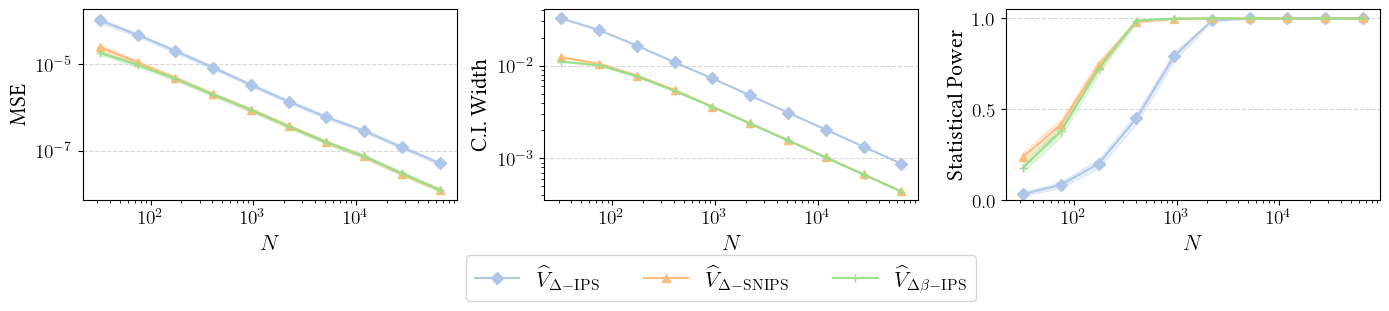

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 2.75))
fontsize=18

for idx, (estimator_name, N2MSE) in enumerate(estimator2N2MSE.items()):
    #Ns = np.asarray(list(N2MSE.keys()))
    
    MSE = np.asarray([
        np.mean(N2MSE[N]) for N in Ns
    ])
    MSE_stderr = np.asarray([
        np.std(N2MSE[N]) / np.sqrt(num_iter) for N in Ns
    ])
    
    axes[0].plot(Ns, MSE, color=estimator2colour[estimator_name], markevery=1, marker=estimator2marker[estimator_name], label=estimator_name)
    axes[0].fill_between(Ns,
                         MSE-1.96*MSE_stderr,
                         MSE+1.96*MSE_stderr,
                         alpha=.25, color=estimator2colour[estimator_name])
    
    if estimator_name in [e[0] for e in estimators]:

        mean_stderr = np.asarray([
            2.0 * 1.96 * np.mean(estimator2N2stderr[estimator_name][N]) for N in Ns
        ])
        stderr_stderr = np.asarray([
            np.std(estimator2N2stderr[estimator_name][N]) / np.sqrt(num_iter) for N in Ns
        ])
        axes[1].plot(Ns, mean_stderr, color=estimator2colour[estimator_name], markevery=1, marker=estimator2marker[estimator_name], label=estimator_name)
        axes[1].fill_between(Ns,
                             mean_stderr-1.96*stderr_stderr,
                             mean_stderr+1.96*stderr_stderr,
                             alpha=.25, color=estimator2colour[estimator_name])

    
    # TODO: Wilson confidence intervals
    mean_statsig = np.asarray([
        np.mean(estimator2N2statsig[estimator_name][N]) for N in Ns
    ])
    stderr_statsig = np.asarray([
        np.std(estimator2N2statsig[estimator_name][N]) / np.sqrt(num_iter) for N in Ns
    ])
    
    axes[2].plot(Ns, mean_statsig, color=estimator2colour[estimator_name], markevery=1, marker=estimator2marker[estimator_name], label=estimator_name)
    axes[2].fill_between(Ns,
                         mean_statsig-1.96*stderr_statsig,
                         mean_statsig+1.96*stderr_statsig,
                         alpha=.25, color=estimator2colour[estimator_name])
    
    
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[0].set_ylabel('MSE', fontsize=fontsize-2)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[1].set_ylabel('C.I. Width', fontsize=fontsize-2)


axes[2].set_xscale('log')
axes[2].set_xlabel(r'$N$', fontsize=fontsize-2)
axes[2].set_ylabel('Statistical Power', fontsize=fontsize-2)



axes[2].set_ylim(0.0, 1.05)

axes[0].grid(axis='y', ls='--', alpha=.5)
axes[1].grid(axis='y', ls='--', alpha=.5)
axes[2].grid(axis='y', ls='--', alpha=.5)

for ax in axes:
    ax.xaxis.set_tick_params(labelsize=fontsize-4)            
    ax.yaxis.set_tick_params(labelsize=fontsize-4)

fig.tight_layout()
axes[2].legend(fontsize=fontsize-2, ncol=3, loc='upper right', bbox_to_anchor=(-0.05,-.23))
    
plt.savefig('DeltaBetaIPS_ContinuousExperiment.pdf', bbox_inches='tight')
plt.show()

In [16]:
(2 ** np.arange(11, 12).astype(int))

array([2048])

In [17]:
2**11

2048